This notebook uses the packages __pandas__ (loads datasets and output tables), __numpy__ (label formatting), and __matplotlib__ (contains module for plotting graphs). In this project, the datasets used are the __gisette__, __madelon__, and __dexter__ datasets. The folders containing the three datasets must be in the same directory as this notebook.

In order to run the code for this project, the following packages must be imported first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import inf

The style and size used for graph and fonts were found in:
https://www.kdnuggets.com/2019/04/data-visualization-python-matplotlib-seaborn.html

In [2]:
# style and size for graph fonts
fontdict_title = {'fontsize': 24, 'weight': 'bold', 'horizontalalignment': 'center'}
fontdict_xlabel = {'fontsize': 18, 'weight': 'bold', 'horizontalalignment': 'center'}
fontdict_ylabel = {'fontsize': 16, 'weight': 'bold', 'horizontalalignment': 'center', 'verticalalignment': 'baseline'}

Helper functions

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def log_loss(labels, h):
    return np.sum(np.log(1 + np.exp(-2 * np.multiply(labels, h))))


def misclassification_error(preds, labels):
    return np.where(preds != labels, 1, 0).mean()


def predictions(features, betas):
    return np.sign(np.dot(features, betas))

Logitboost Algorithm

In [4]:
def logitboost(features, labels, boosted_iterations):
    observation_num, features_num = features.shape
    betas = np.zeros(features_num)
    loss = []

    for iteration in range(boosted_iterations):
        h_x = np.dot(features, betas)
        prob = sigmoid(2 * h_x)
        weights = prob * (1 - prob)
        weights[abs(weights) < 1.e-20] = 1.e-20
        z = np.divide(((labels + 1) / 2 - prob), weights)

        coef = np.matrix(np.zeros((2, features_num - 1)))
        min_loss = inf
        min_index = 0
        for num in range(features_num - 1):
            feature = features[:, num + 1]
            weight_sum = np.sum(weights)
            wx = np.dot(weights, feature)
            wxsquared = np.dot(weights, feature ** 2)
            wz = np.dot(weights, z)
            wxz = np.dot(np.multiply(weights, feature), z)

            if (weight_sum * wxsquared) == (wx ** 2):
                betas_i = np.array([wz / weight_sum, 0])
            else:
                betas_i = 1 / (weight_sum * wxsquared - wx ** 2) * np.array([wxsquared * wz - wx * wxz,
                                                                             weight_sum * wxz - wx * wz])

            h_i = h_x + 1 / 2 * (betas_i[0] + np.multiply(betas_i[1], feature))
            loss_i = log_loss(labels, h_i)
            coef[:, num] = betas_i.reshape((2, 1))

            if loss_i < min_loss:
                min_index = num
                min_loss = loss_i

        betas[0] = betas[0] + 1 / 2 * coef[0, min_index]
        betas[min_index + 1] = betas[min_index + 1] + 1 / 2 * coef[1, min_index]
        loss.append(min_loss)

    return betas, loss

These are the numbers of boosted iterations used for each logitboost classifier:

In [5]:
ks = [10, 30, 100, 300, 500]

# Problem 1) Logitboost Classifier

## A) Gisette Dataset

### Training and Testing

Load training and test set.

In [6]:
gisette_train_data = pd.read_csv("./Gisette/gisette_train.data", header=None, sep=" ").dropna(axis=1).values
gisette_train_labels = np.ravel(pd.read_csv("./Gisette/gisette_train.labels", header=None).values)

gisette_test_data = pd.read_csv("./Gisette/gisette_valid.data", header=None, sep=" ").dropna(axis=1).values
gisette_test_labels = np.ravel(pd.read_csv('./Gisette/gisette_valid.labels', header=None).values)

Add intercept column.

In [7]:
intercept_train = np.ones((gisette_train_data.shape[0], 1))
intercept_test = np.ones((gisette_test_data.shape[0], 1))
gisette_train_data = np.hstack((intercept_train, gisette_train_data))
gisette_test_data = np.hstack((intercept_test, gisette_test_data))

Calculate train and test misclassification errors and loss.

In [8]:
gisette_misclassification_errors = {
    "train": [],
    "test": []
}

for k in ks:
    gisette_betas, l = logitboost(gisette_train_data, gisette_train_labels, k)
    if k == 500:
        gisette_train_loss_500=l

    gisette_train_predictions = predictions(gisette_train_data, gisette_betas)
    gisette_test_predictions = predictions(gisette_test_data, gisette_betas)

    gisette_misclassification_errors["train"].append(misclassification_error(gisette_train_predictions,
                                                                             gisette_train_labels))
    gisette_misclassification_errors["test"].append(misclassification_error(gisette_test_predictions,
                                                                            gisette_test_labels))

### Training Loss vs Boosted Iteration Plot

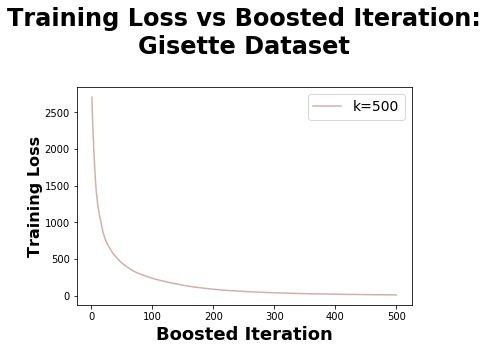

In [9]:
fig = plt.figure()
# size of graph
plt.rcParams['figure.figsize'] = [15, 10]  # size=15x10 inches

# labels
plt.title("Training Loss vs Boosted Iteration:\nGisette Dataset\n", fontdict=fontdict_title)
plt.xlabel("Boosted Iteration", fontdict=fontdict_xlabel)
plt.ylabel("Training Loss", fontdict=fontdict_ylabel)

# plotting
plt.plot(list(range(1,501)), gisette_train_loss_500,
         color="#CDB1AD",
         linestyle="-",
         label="k=500");
plt.legend(fontsize=14);

### Training and Test Misclassification Errors Table

In [10]:
# Create labels
rows_labels = ks
columns_labels = ["Boosted Iterations(k)", "Gisette Train Misclassification Error",
                  "Gisette Test Misclassification Error"]

# Store the misclassification error from each dataset for training and testing
misclassification_errors = {
    columns_labels[1]: gisette_misclassification_errors["train"],
    columns_labels[2]: gisette_misclassification_errors["test"],
}

# Create dataframe to output table
error_tabledf=pd.DataFrame(misclassification_errors, index=rows_labels)
error_tabledf.index.name = columns_labels[0]
error_tabledf

,Gisette Train Misclassification Error,Gisette Test Misclassification Error
Boosted Iterations(k),,
10,0.074667,0.087
30,0.033667,0.038
100,0.012500,0.030
300,0.000000,0.027
500,0.000000,0.025


### Training and Test Misclassification Errors vs Boosted Iterations Plot

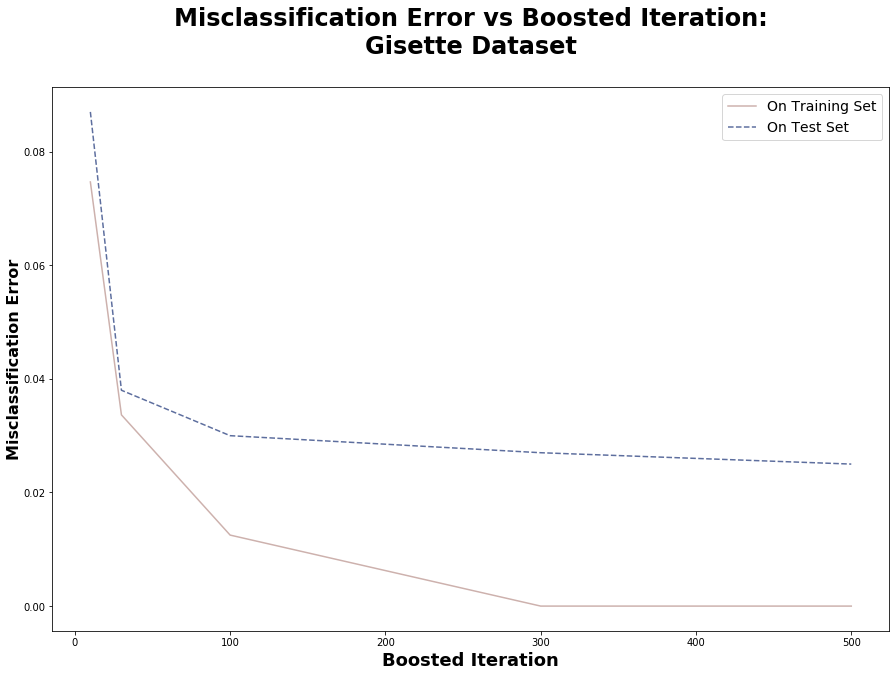

In [11]:
fig = plt.figure()
# size of graph
plt.rcParams['figure.figsize'] = [15, 10]  # size=15x10 inches

# labels
plt.title("Misclassification Error vs Boosted Iteration:\nGisette Dataset\n", fontdict=fontdict_title)
plt.xlabel("Boosted Iteration", fontdict=fontdict_xlabel)
plt.ylabel("Misclassification Error", fontdict=fontdict_ylabel)

# plotting
plt.plot(ks, gisette_misclassification_errors["train"],
         color="#CDB1AD",
         linestyle="-",
         label="On Training Set")
plt.plot(ks, gisette_misclassification_errors["test"],
         color="#5D6E9E",
         linestyle="--",
         label="On Test Set")
plt.legend(fontsize=14);

## B) Dexter Dataset

### Training and Testing

Reformat __dexter_train.data__ and __dexter_test.data__ in order to load it with pandas.

In [12]:
def reformat_file(input_filepath, output_filepath, row_num, col_num):
    output_file = open(output_filepath, "w+")
    with open(input_filepath, "r") as fp:
        for obs in range(0, row_num):
            line = fp.readline()
            strs = line.split(" ")
            output_line = ["0" for col in range(0, col_num)]

            for s in strs:
                if s != "\n":
                    i, value = s.split(":")
                    output_line[int(i)] = value

            output_file.write(",".join(output_line) + "\n")

    output_file.close()

reformat_file("./dexter/dexter_train.data", "./dexter/dexter_train.csv", 300, 20000)
reformat_file("./dexter/dexter_valid.data", "./dexter/dexter_valid.csv", 300, 20000)

Load training and test set.

In [13]:
dexter_train_data = pd.read_csv("./dexter/dexter_train.csv", header=None).values
dexter_train_labels = np.ravel(pd.read_csv("./dexter/dexter_train.labels", header=None).values)
dexter_test_data = pd.read_csv("./dexter/dexter_valid.csv", header=None).values
dexter_test_labels = np.ravel(pd.read_csv("./dexter/dexter_valid.labels", header=None).values)

Add intercept column.

In [14]:
intercept_train = np.ones((dexter_train_data.shape[0], 1))
intercept_test = np.ones((dexter_test_data.shape[0], 1))
dexter_train_data = np.hstack((intercept_train, dexter_train_data))
dexter_test_data = np.hstack((intercept_test, dexter_test_data))

Calculate train and test misclassification errors and loss for each k.

In [15]:
dexter_misclassification_errors = {
    "train": [],
    "test": []
}

for k in ks:
    dexter_betas, l = logitboost(dexter_train_data, dexter_train_labels, k)
    if k == 500:
        dexter_train_loss_500=l

    dexter_train_predictions = predictions(dexter_train_data, dexter_betas)
    dexter_test_predictions = predictions(dexter_test_data, dexter_betas)

    dexter_misclassification_errors["train"].append(misclassification_error(dexter_train_predictions,
                                                                             dexter_train_labels))
    dexter_misclassification_errors["test"].append(misclassification_error(dexter_test_predictions,
                                                                            dexter_test_labels))

### Training Loss vs Boosted Iteration Plot

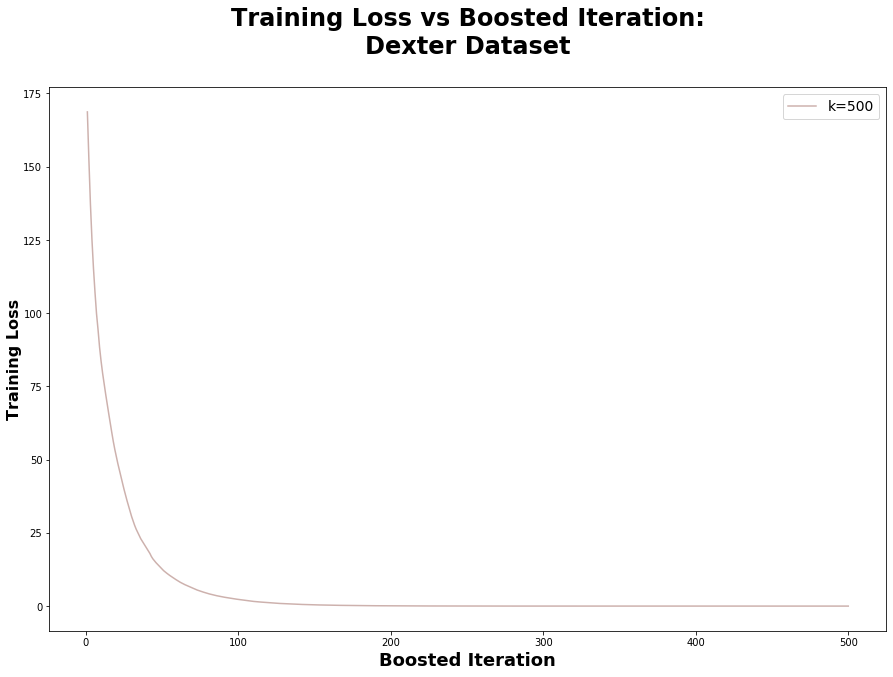

In [16]:
fig = plt.figure()
# size of graph
plt.rcParams['figure.figsize'] = [15, 10]  # size=15x10 inches

# labels
plt.title("Training Loss vs Boosted Iteration:\nDexter Dataset\n", fontdict=fontdict_title)
plt.xlabel("Boosted Iteration", fontdict=fontdict_xlabel)
plt.ylabel("Training Loss", fontdict=fontdict_ylabel)

# plotting
plt.plot(list(range(1,501)), dexter_train_loss_500,
         color="#CDB1AD",
         linestyle="-",
         label="k=500");
plt.legend(fontsize=14);

### Training and Test Misclassification Errors Table

In [17]:
# Create labels
rows_labels = ks
columns_labels = ["Boosted Iterations(k)", "Dexter Training Misclassification Error",
                  "Dexter Test Misclassification Error"]

# Store the misclassification error from each dataset for training and testing
misclassification_errors = {
    columns_labels[1]: dexter_misclassification_errors["train"],
    columns_labels[2]: dexter_misclassification_errors["test"],
}

# Create dataframe to output table
error_tabledf=pd.DataFrame(misclassification_errors, index=rows_labels)
error_tabledf.index.name = columns_labels[0]
error_tabledf

,Dexter Training Misclassification Error,Dexter Test Misclassification Error
Boosted Iterations(k),,
10,0.073333,0.106667
30,0.003333,0.093333
100,0.000000,0.090000
300,0.000000,0.083333
500,0.000000,0.086667


### Training and Test Misclassification Errors vs Boosted Iterations Plot

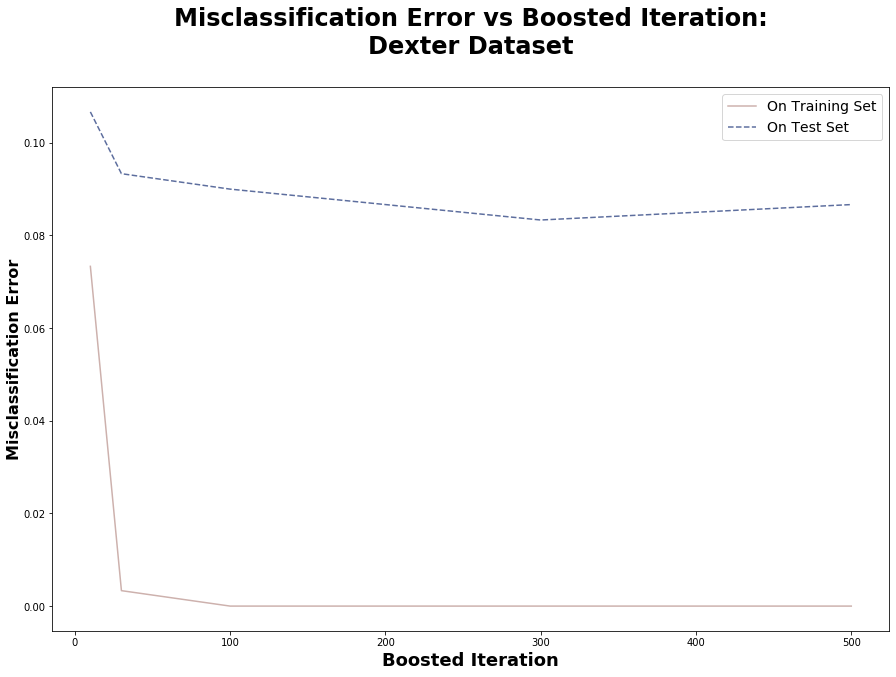

In [18]:
fig = plt.figure()
# size of graph
plt.rcParams['figure.figsize'] = [15, 10]  # size=15x10 inches

# labels
plt.title("Misclassification Error vs Boosted Iteration:\nDexter Dataset\n", fontdict=fontdict_title)
plt.xlabel("Boosted Iteration", fontdict=fontdict_xlabel)
plt.ylabel("Misclassification Error", fontdict=fontdict_ylabel)

# plotting
plt.plot(ks, dexter_misclassification_errors["train"],
         color="#CDB1AD",
         linestyle="-",
         label="On Training Set")
plt.plot(ks, dexter_misclassification_errors["test"],
         color="#5D6E9E",
         linestyle="--",
         label="On Test Set")
plt.legend(fontsize=14);

## C) Madelon Dataset

### Training and Testing

Load training and test set.

In [19]:
madelon_train_data = pd.read_csv("./Madelon/madelon_train.data", header=None, sep=" ").dropna(axis=1).values
madelon_train_labels = np.ravel(pd.read_csv("./Madelon/madelon_train.labels", header=None).values)
madelon_test_data = pd.read_csv("./Madelon/madelon_valid.data", header=None, sep=" ").dropna(axis=1).values
madelon_test_labels = np.ravel(pd.read_csv('./Madelon/madelon_valid.labels', header=None).values)

Add intercept column

In [20]:
intercept_train = np.ones((madelon_train_data.shape[0], 1))
intercept_test = np.ones((madelon_test_data.shape[0], 1))
madelon_train_data = np.hstack((intercept_train, madelon_train_data))
madelon_test_data = np.hstack((intercept_test, madelon_test_data))

Calculate training and testing misclassification errors and loss for each k.

In [21]:
madelon_misclassification_errors = {
    "train": [],
    "test": []
}
for k in ks:
    madelon_betas, l = logitboost(madelon_train_data, madelon_train_labels, k)
    if k == 500:
        madelon_train_loss_500=l

    madelon_train_predictions = predictions(madelon_train_data, madelon_betas)
    madelon_test_predictions = predictions(madelon_test_data, madelon_betas)

    madelon_misclassification_errors["train"].append(misclassification_error(madelon_train_predictions,
                                                                             madelon_train_labels))
    madelon_misclassification_errors["test"].append(misclassification_error(madelon_test_predictions,
                                                                            madelon_test_labels))

### Training Loss vs Boosted Iteration Plot

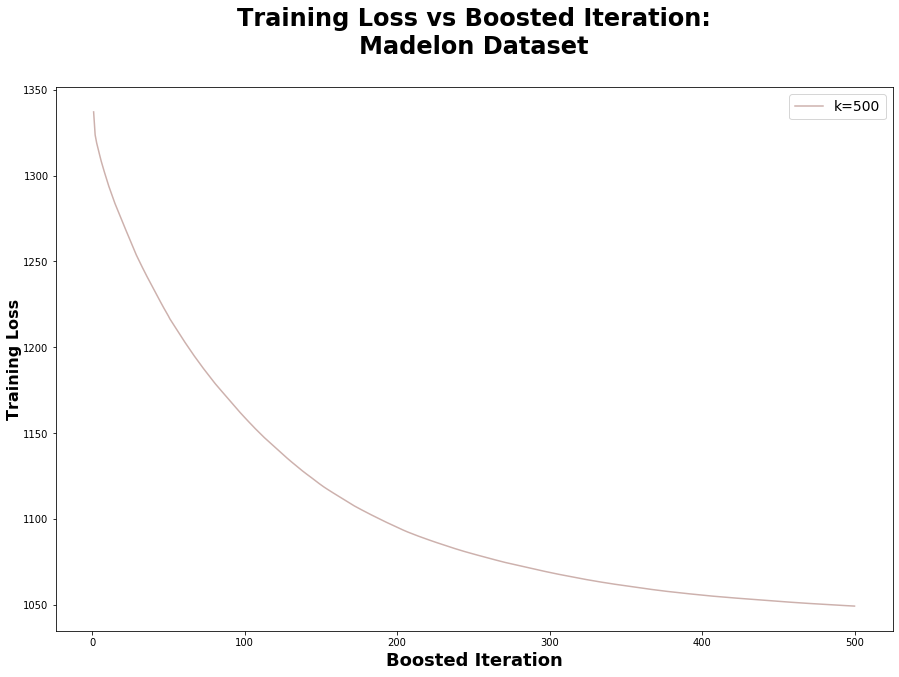

In [22]:
fig = plt.figure()
# size of graph
plt.rcParams['figure.figsize'] = [15, 10]  # size=15x10 inches

# labels
plt.title("Training Loss vs Boosted Iteration:\nMadelon Dataset\n", fontdict=fontdict_title)
plt.xlabel("Boosted Iteration", fontdict=fontdict_xlabel)
plt.ylabel("Training Loss", fontdict=fontdict_ylabel)

# plotting
plt.plot(list(range(1,501)), madelon_train_loss_500,
         color="#CDB1AD",
         linestyle="-",
         label="k=500");
plt.legend(fontsize=14);

### Training and Test Misclassification Errors Table

In [23]:
# Create labels
rows_labels = ks
columns_labels = ["Boosted Iterations(k)", "Madelon Training Misclassification Error",
                  "Madelon Test Misclassification Error"]

# Store the misclassification error from each dataset for training and testing
misclassification_errors = {
    columns_labels[1]: madelon_misclassification_errors["train"],
    columns_labels[2]: madelon_misclassification_errors["test"],
}

# Create dataframe to output table
error_tabledf=pd.DataFrame(misclassification_errors, index=rows_labels)
error_tabledf.index.name = columns_labels[0]
error_tabledf

,Madelon Training Misclassification Error,Madelon Test Misclassification Error
Boosted Iterations(k),,
10,0.3770,0.403333
30,0.3450,0.428333
100,0.3090,0.433333
300,0.2695,0.431667
500,0.2650,0.423333


### Training and Test Misclassification Errors vs Boosted Iterations Plot

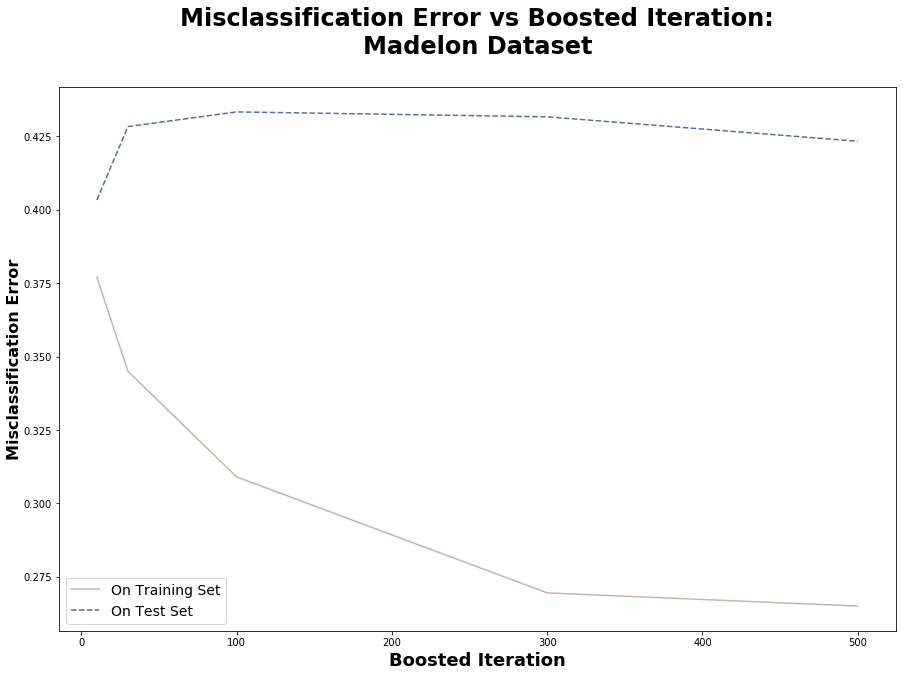

In [24]:
fig = plt.figure()
# size of graph
plt.rcParams['figure.figsize'] = [15, 10]  # size=15x10 inches

# labels
plt.title("Misclassification Error vs Boosted Iteration:\nMadelon Dataset\n", fontdict=fontdict_title)
plt.xlabel("Boosted Iteration", fontdict=fontdict_xlabel)
plt.ylabel("Misclassification Error", fontdict=fontdict_ylabel)

# plotting
plt.plot(ks, madelon_misclassification_errors["train"],
         color="#CDB1AD",
         linestyle="-",
         label="On Training Set")
plt.plot(ks, madelon_misclassification_errors["test"],
         color="#5D6E9E",
         linestyle="--",
         label="On Test Set")
plt.legend(fontsize=14);